
# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

---
### Предобработка исходных данных   


---
#### Данные об электродах:

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv',
                      converters={'Начало нагрева дугой': pd.to_datetime,
                                  'Конец нагрева дугой' : pd.to_datetime})
data_arc.info()
display(data_arc)
data_arc.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Очевидный выброс реактивной мощности -715 заменим на 0.7 величины соответствующей активной мощности:

In [3]:
display(data_arc.loc[ data_arc['Реактивная мощность'] < 0 , : ])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [4]:
data_arc.loc[ data_arc['Реактивная мощность'] < 0 , 'Реактивная мощность' ] = 0.495782 * 0.7
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500713
std,934.571502,0.408159,0.310873
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


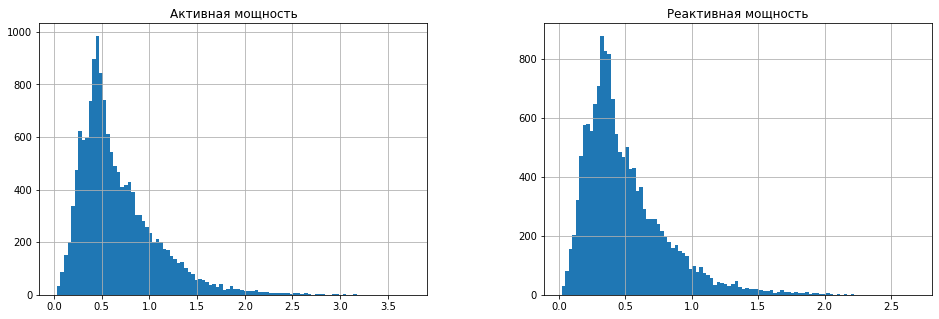

In [5]:
data_arc.iloc[:,[3,4]].hist(bins=100, figsize=(16,5))
plt.show()

---
#### Результаты измерения температуры:

In [6]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv',
                        converters={'Время замера': pd.to_datetime})
data_temp.info()
display(data_temp)
data_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


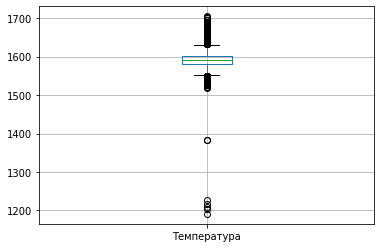

In [7]:
bp = data_temp.boxplot('Температура')

Вероятно температуры ниже 1400 не соответствуют действительности:

In [8]:
dubious_data = set(data_temp.query('Температура < 1400').key)
dubious_data

{867, 1214, 1619, 1818, 2052, 2561}

In [9]:
data_temp.query('key in @dubious_data')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


заменим на среднее значение 1591:

In [10]:
data_temp.loc[ data_temp['Температура'] < 1400, 'Температура' ] = 1591

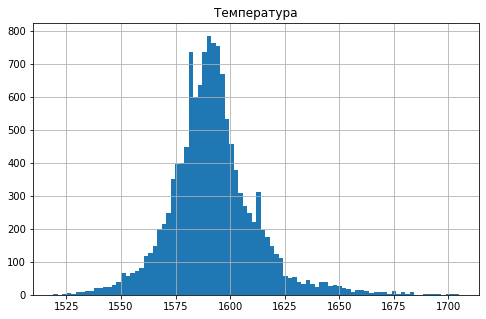

In [11]:
data_temp.hist('Температура', bins=90, figsize=(8,5))
plt.show()

---
####  Данные о продувке сплава газом:

In [12]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', index_col='key')
data_gas.columns = ['gas']
data_gas.info()
display(data_gas)
data_gas.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
gas    3239 non-null float64
dtypes: float64(1)
memory usage: 50.6 KB


,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


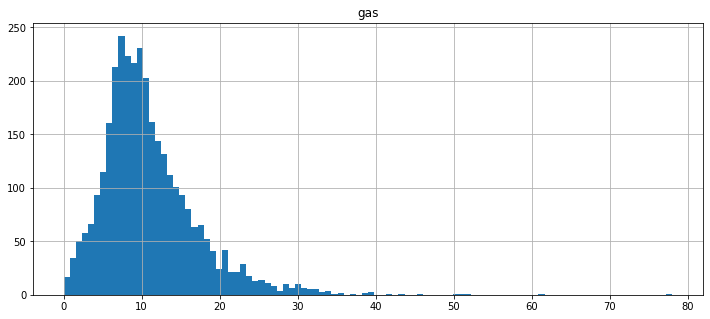

In [13]:
data_gas.hist(bins=100, figsize=(12,5))
plt.show()

---
#### Данные о подаче сыпучих материалов:

In [14]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', index_col='key')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', index_col='key')

In [15]:
data_bulk.info()
display(data_bulk.describe().T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15)
memory usage: 391.1 KB


,count,mean,std,min,25%,50%,75%,max
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0
Bulk 10,176.0,83.284091,26.060347,24.0,64.00,86.5,102.00,159.0


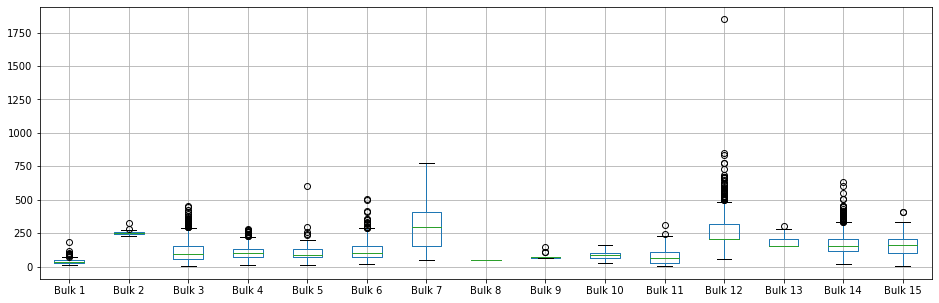

In [16]:
bp = data_bulk.boxplot(figsize=(16,5))

In [17]:
data_bulk = data_bulk.fillna(0)
data_bulk_time = data_bulk_time.astype('datetime64[ns]')

---
#### Данные о проволочных материалах:

In [18]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', index_col='key')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', index_col='key')

In [19]:
data_wire.info()
display(data_wire.describe().T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9)
memory usage: 240.7 KB


,count,mean,std,min,25%,50%,75%,max
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060484,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


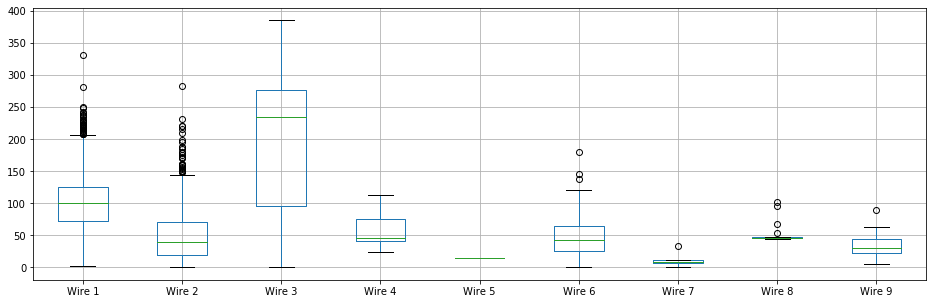

In [20]:
bp = data_wire.boxplot(figsize=(16,5))

In [21]:
data_wire = data_wire.fillna(0)
data_wire_time = data_wire_time.astype('datetime64[ns]')

---
### План дальнейших действий:

<div class="alert alert-block alert-info">

1. ___Выделить целевой признак:___  

    - будем предсказывать температуру расплава непосредственно   перед передачей  
    на дальнейшую переработку (на доводку металла или в машину непрерывной разливки).  
    Т.е. измерение этой температуры должна быть последней операцией в данной партии.   
    
    
    
2. ___Сформировать признаки для обучения модели:___

    - из данных по электродам вычислить количество внесенной энергии  
    (сумма произведений активной мощности на время воздействия в данной партии)   
    - из результатов измерения температуры извлечь начальную температуру расплава  
    и время нахождения расплава в ковше  
    - данные по продувке газом, подаче сыпучих и проволочных материалов  
    присоединить по номеру партии в таблицу признаков
    
    
3. ___Выделить тренировочную и тестовую выборку___   

    - в пропорции 75% - 25%


4. ___Обучить несколько моделей на тренировочной выборке с целевой метрикой MAE___


5. ___Выбрать лучшую модель на тестовых данных___


6. ___Определить влияние признаков на предсказание модели___ 


### Подготовка признаков:

In [22]:
data_temp = data_temp.fillna(0)
data = data_temp.pivot_table(index='key', aggfunc=('first', 'last'))
data.columns = ['in_time', 'out_time', 'temp_in', 'temp_out']

data['duration'] = (data.out_time - data.in_time) / np.timedelta64(1, 's')
data = data.query('temp_out > 0 and duration > 0').drop('in_time', axis=1)
data

,out_time,temp_in,temp_out,duration
key,,,,
1,2019-05-03 11:30:39,1571.0,1613.0,861.0
2,2019-05-03 11:59:12,1581.0,1602.0,1305.0
3,2019-05-03 12:34:57,1596.0,1599.0,1300.0
4,2019-05-03 12:59:25,1601.0,1625.0,388.0
5,2019-05-03 13:36:01,1576.0,1602.0,762.0
...,...,...,...,...
2495,2019-08-06 00:54:42,1570.0,1591.0,1137.0
2496,2019-08-06 01:29:52,1554.0,1591.0,1618.0
2497,2019-08-06 01:53:50,1571.0,1589.0,717.0


In [23]:
last_bulk = data_bulk_time.max(axis=1)
last_wire = data_wire_time.max(axis=1)
last_additions = pd.DataFrame({'last_bulk':last_bulk, 'last_wire':last_wire})
data = data.join(last_additions)
data

,out_time,temp_in,temp_out,duration,last_bulk,last_wire
key,,,,,,
1,2019-05-03 11:30:39,1571.0,1613.0,861.0,2019-05-03 11:21:30,2019-05-03 11:11:41
2,2019-05-03 11:59:12,1581.0,1602.0,1305.0,2019-05-03 11:46:38,2019-05-03 11:46:10
3,2019-05-03 12:34:57,1596.0,1599.0,1300.0,2019-05-03 12:31:06,2019-05-03 12:13:47
4,2019-05-03 12:59:25,1601.0,1625.0,388.0,2019-05-03 12:48:43,2019-05-03 12:48:05
5,2019-05-03 13:36:01,1576.0,1602.0,762.0,2019-05-03 13:18:50,2019-05-03 13:32:06
...,...,...,...,...,...,...
2495,2019-08-06 00:54:42,1570.0,1591.0,1137.0,2019-08-06 00:49:21,2019-08-06 00:36:13
2496,2019-08-06 01:29:52,1554.0,1591.0,1618.0,2019-08-06 01:14:16,2019-08-06 01:13:33
2497,2019-08-06 01:53:50,1571.0,1589.0,717.0,2019-08-06 01:43:02,2019-08-06 01:42:51


оставим партии, где измерение температуры - последняя операция, и удалим вспомогательные параметры:

In [24]:
data = data.query('last_bulk < out_time and last_wire < out_time')
data = data.drop(['out_time', 'last_bulk', 'last_wire'], axis=1)
data

,temp_in,temp_out,duration
key,,,
1,1571.0,1613.0,861.0
2,1581.0,1602.0,1305.0
3,1596.0,1599.0,1300.0
4,1601.0,1625.0,388.0
5,1576.0,1602.0,762.0
...,...,...,...
2495,1570.0,1591.0,1137.0
2496,1554.0,1591.0,1618.0
2497,1571.0,1589.0,717.0


расчет электроэнергии затраченной на нагрев каждой партии:

In [25]:
data_arc['energy'] = ((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) / 
                       np.timedelta64(1, 's') * data_arc['Активная мощность'])
data_energy = data_arc.pivot_table(index='key', aggfunc={'energy':'sum'})
data_energy

,energy
key,
1,1207.804249
2,733.816470
3,443.583327
4,670.663327
5,997.496095
...,...
3237,777.993447
3238,432.849310
3239,844.977151


объединим все потенциально важные параметры:

In [26]:
data = data.join([data_energy, data_gas, data_bulk, data_wire])
data = data.drop(['Bulk 8', 'Wire 5'], axis=1) # эти добавки использовались всего лишь по одному разу - удаляем
data

,temp_in,temp_out,duration,energy,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1207.804249,29.749986,0.0,0.0,0.0,43.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,1305.0,733.816470,12.555561,0.0,0.0,0.0,73.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,1300.0,443.583327,28.554793,0.0,0.0,0.0,34.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,388.0,670.663327,18.841219,0.0,0.0,0.0,81.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,762.0,997.496095,5.413692,0.0,0.0,0.0,78.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,1137.0,626.167357,7.125735,0.0,0.0,21.0,0.0,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2496,1554.0,1591.0,1618.0,727.868032,9.412616,0.0,0.0,0.0,63.0,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2497,1571.0,1589.0,717.0,427.535518,6.271699,0.0,0.0,0.0,85.0,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_in,2322.0,1587.365633,23.567723,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
temp_out,2322.0,1593.361757,11.187103,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
duration,2322.0,1900.195090,1322.188194,234.000000,1221.000000,1635.500000,2295.750000,23537.000000
energy,2322.0,721.215164,520.784233,10.614857,373.149110,610.677609,929.656690,8624.443403
gas,2320.0,11.387265,6.393307,0.008399,7.294619,10.106744,14.218487,77.995040
Bulk 1,2322.0,3.437984,12.429405,0.000000,0.000000,0.000000,0.000000,185.000000
Bulk 2,2322.0,1.426787,19.110712,0.000000,0.000000,0.000000,0.000000,325.000000
Bulk 3,2322.0,47.309216,75.338758,0.000000,0.000000,0.000000,79.750000,454.000000
Bulk 4,2322.0,37.360896,58.753252,0.000000,0.000000,0.000000,77.000000,281.000000
Bulk 5,2322.0,2.648148,22.435580,0.000000,0.000000,0.000000,0.000000,603.000000


In [28]:
target = data['temp_out']
features = data.drop('temp_out', axis=1)
features = features.fillna(0)

In [29]:
corr = features.corr()
for row in range(1, corr.shape[0]):
    for col in range(0, row):
        c = corr.iloc[row, col]
        if np.abs(c) > 0.7:
            print(corr.index[row], corr.columns[col], round(c, 2))

Wire 4 Bulk 7 0.74
Wire 8 Bulk 9 0.97


In [30]:
features = features.drop(['Bulk 9'], axis=1) # удалим сильно коррелированные признаки

### Обучение моделей:

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [32]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.25, random_state=321)

In [33]:
def score(model):
    display(pd.DataFrame({'MAE':[mean_absolute_error(model.predict(features_train), target_train),
                                 mean_absolute_error(model.predict(features_test), target_test)]}, 
                         index=['Тренировочная выборка', 'Тестовая выборка']))

---
#### Линейная регрессия:

In [34]:
model_LR = LinearRegression()

In [35]:
%%time

model_LR.fit(features_train, target_train)

CPU times: user 0 ns, sys: 9.49 ms, total: 9.49 ms
Wall time: 3.44 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
score(model_LR)

,MAE
Тренировочная выборка,5.900850
Тестовая выборка,6.130912


---
#### Случайный лес:

In [37]:
parameters = [{'n_estimators': [100, 200, 400],
               'max_depth': [5, 10, 20],
               'max_leaf_nodes': [100, 200]}]

In [38]:
model_RF = GridSearchCV(RandomForestRegressor(random_state=321), 
                        parameters, scoring='neg_mean_absolute_error', cv=3)

In [39]:
%%time

model_RF.fit(features_train, target_train)

CPU times: user 1min 6s, sys: 217 ms, total: 1min 6s
Wall time: 1min 6s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=321,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 20],
     

In [40]:
model_RF.best_params_

{'max_depth': 20, 'max_leaf_nodes': 100, 'n_estimators': 400}

In [41]:
score(model_RF)

,MAE
Тренировочная выборка,4.066280
Тестовая выборка,6.088051


---
#### CatBoost:

In [42]:
%%time 

model_CB = CatBoostRegressor(loss_function='MAE') 

parameters = {'depth':[3, 6], 
              'learning_rate':[0.1, 0.3],
              'iterations':[100, 200, 400]}

cb_grid = model_CB.grid_search(parameters, 
                         Pool(features_train, target_train), 
                         cv=3, verbose=False)

CPU times: user 38 s, sys: 4.19 s, total: 42.1 s
Wall time: 1min 4s


In [43]:
cb_grid['params']

{'depth': 3, 'iterations': 400, 'learning_rate': 0.1}

In [44]:
score(model_CB)

,MAE
Тренировочная выборка,4.521773
Тестовая выборка,5.897653


###  Выбор модели

__Наилучший результат показала модель CatBoost__  

---
Рассмотрим значимость признаков:

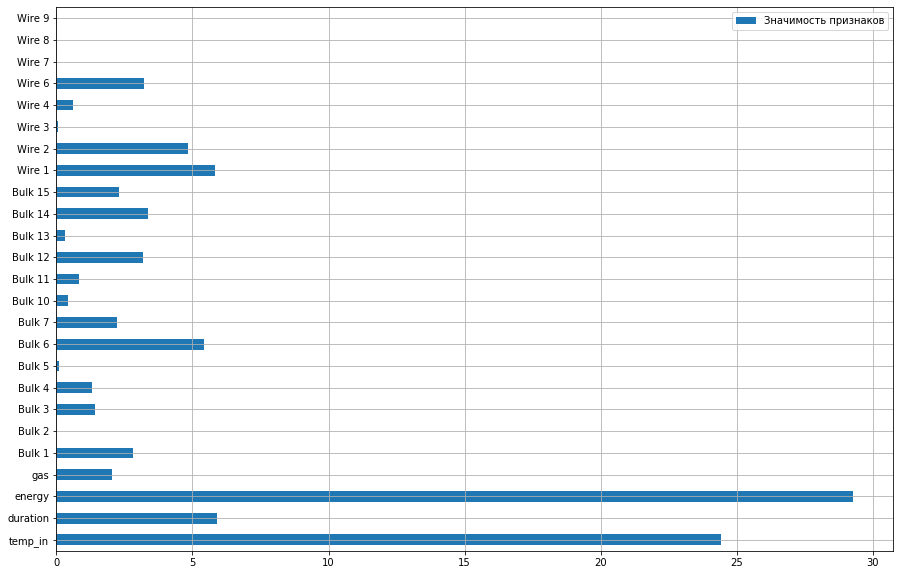

In [45]:
ax = pd.DataFrame(model_CB.feature_importances_, 
                  columns=['Значимость признаков'], 
                  index=features_train.columns).plot(kind='barh', grid=True, figsize=(15,10))

удалим малозначимые признаки:

In [46]:
features = features.drop(['Wire 9', 'Wire 8', 'Wire 7', 'Wire 4', 'Wire 3', 
                          'Bulk 13', 'Bulk 10', 'Bulk 5', 'Bulk 2'], axis=1)
features.shape

(2322, 16)

In [47]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.25, random_state=321)

In [48]:
%%time 

model = CatBoostRegressor(loss_function='MAE') 

parameters = {'depth':[3, 6], 
              'learning_rate':[0.1, 0.3],
              'iterations':[100, 200, 400]}

cb_grid = model.grid_search(parameters, 
                            Pool(features_train, target_train), 
                            cv=3, verbose=False)

CPU times: user 34.9 s, sys: 4.4 s, total: 39.3 s
Wall time: 53.1 s


<div class="alert alert-block alert-info">   
    
---
___Окончательный вариант CatBoostRegressor с параметрами:___

In [49]:
cb_grid['params']

{'depth': 3, 'iterations': 400, 'learning_rate': 0.1}

In [50]:
score(model)

,MAE
Тренировочная выборка,4.480511
Тестовая выборка,5.925476


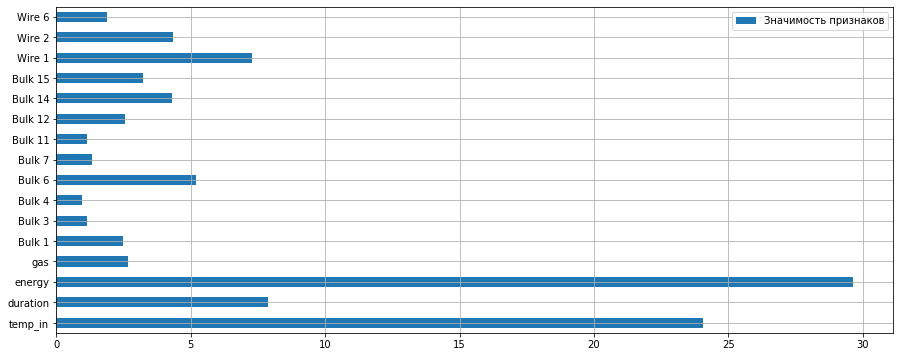

In [51]:
ax = pd.DataFrame(model.feature_importances_, 
                  columns=['Значимость признаков'], 
                  index=features_train.columns).plot(kind='barh', grid=True, figsize=(15,6))

<div class="alert alert-block alert-info">
    
Добрый день. Я думаю в реальном проекте следовало бы рассмотреть гораздо больше факторов. Классы точности приборов, например. Или как  организован технологический процесс. Он уже дает неплохой результат - МАЕ от среднего значения:

In [52]:
from sklearn.dummy import DummyRegressor
score(DummyRegressor().fit(features_train, target_train))

,MAE
Тренировочная выборка,7.978020
Тестовая выборка,8.305809


<div class="alert alert-block alert-info">
    
$8^oC$ при измеряемой температуре порядка $1600^oC$ - это всегог лишь 0.5%  
    
Так же неизвестно насколько точно есть возможность дозировать нагрев. Может быть есть смысл оптимизировать (уменьшить) количество включений или мощность. Но это уже надо знать электрическую схему установки.

### Отчет

****Ключевые шаги:****

---
- ***изучение этапа обработки стали:***  
Поскольку агрегатное состояние стали не меняется, становится понятно,  
что температура практически линейно зависит от тепловой энергии расплава.  
Энергия расплава увеличивается при помощи угольных электродов прямо пропорционально  
количеству подведенной активной электрической энергии.  
Энергия расплава уменьшается за счет утечки тепла в окружающую среду через  
теплоизоляцию ковша, а так же при продувке расплава инертным газом и  
при добавлении легирующих добавок.  
Исходя из этого формировались признаки для обучения моделей.  
Важный параметр - масса расплава - не предоставлен, поэтому предполагаем,  
что масса расплава во всех примерах одинакова. То же относится и к теплоизоляции  
ковша (это либо один и тот же ковш, либо идентичен по теплоизолирующим свойствам)

---
- ***предобработка данных:***  
Исправлены очевидные ошибки в реактивной мощности и температурах.  
Некоторые значения в расходе газа и легирующих добавок выглядят как выбросы,  
но ввиду недостатка информации решил оставить их в датасетах.

---

- ***формирование и предварительный отбор признаков:***  
Расчитано количество электрической энергии, затраченной на нагрев каждой партии.  
Расчитано время нахождения в ковше.  
Удалены ненужные признаки, сильнокоррелированные признаки  
а так же редкие признаки (единичное использование)  
Все признаки объединены в один датасет.  
В партиях, где не использовался газ или легирующие добавки, пропуски заполнены нулями.  
Оставлены только записи, в которых известна начальная и конечная температуры,  
и после последнего измерения температуры больше не проводилось никаких операций.

---
- ***подготовка данных для обучения и тестирования моделей:***  
Конечная температура выделена в качестве цели.  
Данные разделены в пропорции 75% - 25% для обучения и тестирования моделей.

---
- ***выбор наиболее подходящей модели:***  
Рассмотрены модели LinearRegression, RandomForestRegressor и  CatBoostRegressor.  
Для двух последних моделей гиперпараметры подбирались при помощи кроссвалидации.   
Наилучшую метрику MAE удалось получить с помощью CatBoostRegressor

---
- ***оценка значимости признаков и окончательный отбор признаков:***  
После удаления малозначимых признаков осталось 16 значимых,  
при этом качество модели практически не изменилось.

---


****Итоговая модель:****

***CatBoostRegressor***   



In [53]:
print('Параметры модели', model.get_params())
score(model)

Параметры модели {'loss_function': 'MAE', 'depth': 3, 'iterations': 400, 'learning_rate': 0.1}


,MAE
Тренировочная выборка,4.480511
Тестовая выборка,5.925476
